# Implementing ALM From Scratch in PyTorch

If you're reading this, you're probably more used than PyTorch than Jax. That is unfortunate for all of us (just kidding). Nevertheless, for this reason, we'll implement a naive version of cross-tokenizer distillation via Approximate Likelihood Matching (as introduced in [our paper](https://arxiv.org/abs/2503.20083)) from scratch in PyTorch in this guide. This should be useful if you'd like to add an ALM objective alongside your own PyTorch training procedure instead of using `tokenkit`.

We will start from the alignment algorithm we discussed in the [byteification](./byteification.md) guide, and we'll make the (somewhat arbitrary) choice of using Gemma2-2B and Llama3-3B as the student and the teacher, respectively.

In [1]:
import torch
import transformers
import matplotlib
import tokenkit
import os

from transformers import AutoModelForCausalLM
import matplotlib.pyplot as plt

from tokenkit import align, utils
from tokenkit.byteify import load_byteify_tokenizer

In [2]:
print("torch version:", torch.__version__)
print("transformers version:", transformers.__version__)
print("matplotlib version:", matplotlib.__version__)

print("tokenkit commit sha:")
!cd {os.path.dirname(tokenkit.__file__)}; git log -1 --pretty=format:"%H"

torch version: 2.6.0+cu124
transformers version: 4.46.0
matplotlib version: 3.10.1
tokenkit commit sha:
7b57aab49a2a95fd8c36080de0a39950b5221122

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [3]:
teacher_model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.2-3B-Instruct")
teacher_tokenizer = load_byteify_tokenizer("meta-llama/Llama-3.2-3B-Instruct:source=Llama3")

student_model = AutoModelForCausalLM.from_pretrained("google/gemma-2-2b-it")
student_tokenizer = load_byteify_tokenizer("google/gemma-2-2b-it:source=Gemma2")

2025-04-23 10:45:48.835618: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Define a dummy conversational corpus to use.

## Defining the Data & Tokenizing

In [4]:
text_pairs = [
    [
        {
            "role": "user",
            "content": "How are you doing?"
        },
        {
            "role": "assistant",
            "content": "I'm a large language model, so I'm naturally doing pretty well, thankyouverymuch.",
        }
    ]
]

`tokenkit` supplies custom preprocessing & encoding with more control over the output than `.apply_chat_template` via `preprocess_messages` and `encode_prompt`.

This allows not prepending any hardcoded system prompt (as e.g. in Llama3). This is useful since different system prompts would make sequence alignment harder (and they're generally not needed).

In [5]:
token_ids_teacher = []
token_ids_student = []
tokens_teacher = []
tokens_student = []

for text_pair in text_pairs:
    prompt = utils.preprocess_messages(text_pair)

    ids_teacher = utils.encode_prompt(prompt, teacher_tokenizer)[0]
    ids_student = utils.encode_prompt(prompt, student_tokenizer)[0]

    token_ids_teacher.append(ids_teacher)
    token_ids_student.append(ids_student)
    tokens_teacher.append(teacher_tokenizer.convert_ids_to_tokens(ids_teacher))
    tokens_student.append(student_tokenizer.convert_ids_to_tokens(ids_student))

print(tokens_teacher[0])
print(tokens_student[0])

['<|begin_of_text|>', '<|start_header_id|>', 'user', '<|end_header_id|>', 'ĊĊ', 'How', 'Ġare', 'Ġyou', 'Ġdoing', '?', '<|eot_id|>', '<|start_header_id|>', 'assistant', '<|end_header_id|>', 'ĊĊ', 'I', "'m", 'Ġa', 'Ġlarge', 'Ġlanguage', 'Ġmodel', ',', 'Ġso', 'ĠI', "'m", 'Ġnaturally', 'Ġdoing', 'Ġpretty', 'Ġwell', ',', 'Ġthan', 'ky', 'ou', 'very', 'much', '.', '<|eot_id|>']
['<bos>', '<start_of_turn>', 'user', 'Ċ', 'How', 'Ġare', 'Ġyou', 'Ġdoing', '?', '<end_of_turn>', 'Ċ', '<start_of_turn>', 'model', 'Ċ', 'I', "'", 'm', 'Ġa', 'Ġlarge', 'Ġlanguage', 'Ġmodel', ',', 'Ġso', 'ĠI', "'", 'm', 'Ġnaturally', 'Ġdoing', 'Ġpretty', 'Ġwell', ',', 'Ġthan', 'kyou', 'very', 'much', '.', '<end_of_turn>', 'Ċ']


You can also use `.apply_chat_template` instead, but you'd have to manually strip the hardcoded system prompt.

In [6]:
# ByteifyTokenizer.tokenizer accesses the underlying HF tokenizer
tokens_teacher_ct = teacher_tokenizer.tokenizer.apply_chat_template(text_pairs[0], tokenize=False)
tokens_teacher_ct = teacher_tokenizer.convert_ids_to_tokens(teacher_tokenizer.bos_token_id) + tokens_teacher_ct[tokens_teacher_ct.find("<|start_header_id|>user"):]
assert teacher_tokenizer.tokenize(tokens_teacher_ct) == tokens_teacher[0]

## Computing Token Sequence Alignments

Having computed the tokens, we can now compute alignments. We will use `align.get_alignment_indices` as in the previous guide to compute a matrix mapping *token probabilities* to *chunk probabilities*, separately for the teacher and the student. We will see what this means in detail in a second.

You'd typically do this in your data loading or collation step.


In [7]:
max_length_teacher = max(len(x) for x in tokens_teacher)
max_length_student = max(len(x) for x in tokens_student)
max_n_chunks = min(max_length_teacher, max_length_student)
n_examples = len(text_pairs)

teacher_tokens_to_chunks = torch.zeros((n_examples, max_length_teacher, max_n_chunks), dtype=torch.bool)
student_tokens_to_chunks = torch.zeros((n_examples, max_length_student, max_n_chunks), dtype=torch.bool)

for example_idx, (tteacher, tstudent) in enumerate(zip(tokens_teacher, tokens_student)):
    for chunk_idx, (start1, end1, start2, end2) in enumerate(align.get_alignment_indices(
        tteacher,
        tstudent,
        teacher_tokenizer,
        student_tokenizer
    )[0]):
        teacher_tokens_to_chunks[example_idx, start1:end1, chunk_idx] = 1
        student_tokens_to_chunks[example_idx, start2:end2, chunk_idx] = 1

We now have two 2d matrices which define a mapping of sequences of tokens to a chunk index, where for a given chunk index, the sequences of tokens mapping to it encode the same underlying text for the student and the teacher.

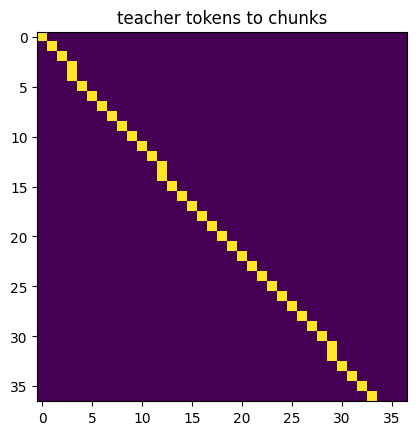

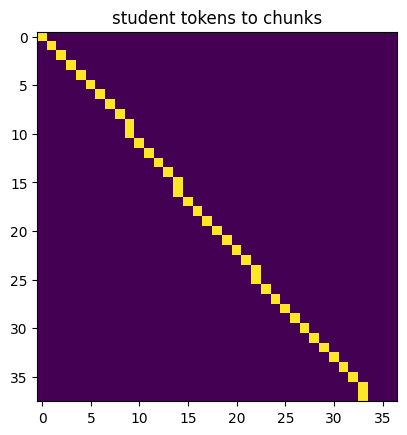

In [8]:
plt.imshow(teacher_tokens_to_chunks[0])
plt.title("teacher tokens to chunks")
plt.show()
plt.imshow(student_tokens_to_chunks[0])
plt.title("student tokens to chunks")
plt.show()

As you can see, these matrices map tokens to chunks, where every chunk consists of one or more tokens, so it is a lower diagonal matrix which is in this case pretty close to diagonal (meaning we have many 1:1 alignments).

However, there are some multi-token chunks. Let's look at them.

In [9]:
multi_token_chunk_indices = sorted(set(torch.where(teacher_tokens_to_chunks[0].sum(-2) > 1)[0]) | set(torch.where(student_tokens_to_chunks[0].sum(-2) > 1)[0]))

for chunk_idx in multi_token_chunk_indices:
    print("Teacher Chunk Tokens:", [tokens_teacher[0][i] for i in torch.where(teacher_tokens_to_chunks[0, :, chunk_idx])[0]])
    print("Student Chunk Tokens:", [tokens_student[0][i] for i in torch.where(student_tokens_to_chunks[0, :, chunk_idx])[0]])
    print()

Teacher Chunk Tokens: ['<|end_header_id|>', 'ĊĊ']
Student Chunk Tokens: ['Ċ']

Teacher Chunk Tokens: ['<|eot_id|>']
Student Chunk Tokens: ['<end_of_turn>', 'Ċ']

Teacher Chunk Tokens: ['<|end_header_id|>', 'ĊĊ']
Student Chunk Tokens: ['Ċ']

Teacher Chunk Tokens: ["'m"]
Student Chunk Tokens: ["'", 'm']

Teacher Chunk Tokens: ["'m"]
Student Chunk Tokens: ["'", 'm']

Teacher Chunk Tokens: ['ky', 'ou']
Student Chunk Tokens: ['kyou']

Teacher Chunk Tokens: ['<|eot_id|>']
Student Chunk Tokens: ['<end_of_turn>', 'Ċ']



But enough time procrastinating, and let's get on with defining the ALM objective!

(just making a quick stop first to pad the ids into a single tensor and define the attention mask)

In [10]:
input_ids_teacher = torch.zeros((n_examples, max_length_teacher), dtype=torch.int64)
input_ids_student = torch.zeros((n_examples, max_length_student), dtype=torch.int64)
attention_mask_teacher = torch.zeros_like(input_ids_teacher)
attention_mask_student = torch.zeros_like(input_ids_student)

for example_idx, (tteacher_ids, tstudent_ids) in enumerate(zip(token_ids_teacher, token_ids_student)):
    input_ids_teacher[example_idx, :len(tteacher_ids)] = torch.tensor(tteacher_ids)
    attention_mask_teacher[example_idx, :len(tteacher_ids)] = 1

    input_ids_student[example_idx, :len(tstudent_ids)] = torch.tensor(tstudent_ids)
    attention_mask_student[example_idx, :len(tstudent_ids)] = 1

## Defining the ALM objective

First, of course, we need to compute logits (and logprobs) from both models:

In [11]:
teacher_logits = teacher_model(input_ids_teacher, attention_mask=attention_mask_teacher).logits
student_logits = student_model(input_ids_student, attention_mask=attention_mask_student).logits

teacher_logprobs = torch.log_softmax(teacher_logits, -1)
student_logprobs = torch.log_softmax(student_logits, -1)

We'll now extract the logprobs along the "main path" (i.e., the likelihoods of the next token among the sequence of tokens we passed to the models).

Here, we have to be careful of the offsets (the model predicts the *next* token) to avoid off-by-one errors.

In [12]:
teacher_main_path_logprobs = torch.take_along_dim(teacher_logprobs[:, :-1], input_ids_teacher[:, 1:, None], dim=-1).squeeze(-1)
student_main_path_logprobs = torch.take_along_dim(student_logprobs[:, :-1], input_ids_student[:, 1:, None], dim=-1).squeeze(-1)

teacher_main_path_logprobs.shape, student_main_path_logprobs.shape

(torch.Size([1, 36]), torch.Size([1, 37]))

We can also check the average main path probability, this should be quite high if things are right.

In [13]:
torch.exp(teacher_main_path_logprobs * attention_mask_teacher[:, :-1]).mean() / attention_mask_teacher[:, :-1].to(torch.float32).mean()

tensor(0.5134, grad_fn=<DivBackward0>)

Now, we get to the core of the ALM objective: minimizing some distance function (we'll use the default, binary cross-entropy with temperature t=100) between the product of token probabilities in every chunk across the teacher and the student. We are operating in log space, so the product of token probabilities becomes the sum of log probs, which we can achieve via a matrix multiplication with the mapping we defined above (again, careful of the offset!).

In [14]:
def log1mexp(x):
    """Computes log(1 - exp(x)) in a numerically stable way for x < 0."""
    # For x < log(0.5), use log1p(-exp(x)) directly
    # For x >= log(0.5), use log(-expm1(x)) to avoid precision issues
    log_half = -torch.log(torch.tensor(2, device=x.device))
    return torch.where(x < log_half, torch.log1p(-torch.exp(x)), torch.log(-torch.expm1(x)))

def distance_fn(log_y_true, log_y_pred, temp=100, epsilon=1e-6):
    log_y_true = (log_y_true.to(torch.float32) / temp) - epsilon
    log_y_pred = (log_y_pred.to(torch.float32) / temp) - epsilon

    return -(
        torch.exp(log_y_true) * log_y_pred
        + (-torch.expm1(log_y_true) * log1mexp(log_y_pred))
    )

In [15]:
teacher_chunk_logprobs = torch.matmul(
    teacher_main_path_logprobs[:, None, :],
    teacher_tokens_to_chunks[:, 1:].to(teacher_main_path_logprobs.dtype),
)
student_chunk_logprobs = torch.matmul(
    student_main_path_logprobs[:, None, :],
    student_tokens_to_chunks[:, 1:].to(student_main_path_logprobs.dtype),
)
# or equivalently, student_tokens_to_chunks[:, 1:].sum(-2) > 0
chunk_mask = teacher_tokens_to_chunks[:, 1:].sum(-2) > 0

In [16]:
elementwise_loss = distance_fn(teacher_chunk_logprobs, student_chunk_logprobs)
loss = (elementwise_loss * chunk_mask).mean() / chunk_mask.to(torch.float32).mean()
loss

tensor(0.1585, grad_fn=<DivBackward0>)

And that's it!

This is a 'naive' version of the ALM loss. Specifically, we have omitted (i) chunk debiasing and (ii) a more sophisticated chunk selection strategy (we are just using the shortest possible chunks). See [the paper](https://arxiv.org/abs/2503.20083) for details on those. 

As you've seen, the main complexity is in the alignment (and byteification), the method to compute the loss itself is actually very simple!

Nonetheless, this version should already get you most of the way there. Especially if you plan to combine ALM with another objective (for example, next-token prediction), this version should be quite good, and should do much better than omitting distillation.

If you're looking for the complete and battle-tested version of ALM that is implemented in `tokenkit`, check out [`tokenkit/training/losses.py`](https://github.com/bminixhofer/tokenkit/blob/main/tokenkit/training/losses.py).